# The Big Mac Index Regression Model
This Notebook outlines all of the steps necessary to create a Regression Model using the price of a Big Mac in three different countries. The basic idea is that historical data is used to build a model that theoretically can be used to infer the price of a Big Mac in those three countries (including the U.S.).

The data source was taken from Kaggle: https://www.kaggle.com/datasets/mrmorj/big-mac-index-data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

## Import Data
I have the data in Google Drive so I can easily get to it. Note that I already removed a bunch of columns from the original Kaggle dataset for simplicity. For example, I am not using the current variations for each country.

In [3]:
original_mac_df = pd.read_csv('/content/drive/MyDrive/tmp/big mac.csv')

## Perform Exploratory Data Analysis
Start with the basics - what's in the dataset.

In [4]:
original_mac_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1386 non-null   object 
 1   iso_a3         1386 non-null   object 
 2   currency_code  1386 non-null   object 
 3   name           1386 non-null   object 
 4   local_price    1386 non-null   float64
 5   dollar_ex      1386 non-null   float64
 6   dollar_price   1386 non-null   float64
dtypes: float64(3), object(4)
memory usage: 75.9+ KB


### Observations
The first four features require some engineering since they are objects. There are no missing values to deal with.

Next, output some of the rows to literally see the data.

In [5]:
original_mac_df.head(10)

,date,iso_a3,currency_code,name,local_price,dollar_ex,dollar_price
0,4/1/2000,ARG,ARS,Argentina,2.50,1.000000,2.500000
1,4/1/2000,AUS,AUD,Australia,2.59,1.680000,1.541667
2,4/1/2000,BRA,BRL,Brazil,2.95,1.790000,1.648045
3,4/1/2000,CAN,CAD,Canada,2.85,1.470000,1.938776
4,4/1/2000,CHE,CHF,Switzerland,5.90,1.700000,3.470588
5,4/1/2000,CHL,CLP,Chile,1260.00,514.000000,2.451362
6,4/1/2000,CHN,CNY,China,9.90,8.280000,1.195652
7,4/1/2000,CZE,CZK,Czech Republic,54.37,39.100000,1.390537
8,4/1/2000,DNK,DKK,Denmark,24.75,8.040000,3.078358
9,4/1/2000,EUZ,EUR,Euro area,2.56,1.075269,2.380800


In [35]:
# I'll need this list when I create the new sample at the bottom of the Notebook.
all_currency_codes_array = original_mac_df['currency_code'].unique()
all_currency_codes_array = np.sort(all_currency_codes_array)
all_currency_codes_array

array(['AED', 'ARS', 'AUD', 'AZN', 'BHD', 'BRL', 'CAD', 'CHF', 'CLP',
       'CNY', 'COP', 'CRC', 'CZK', 'DKK', 'EGP', 'EUR', 'GBP', 'GTQ',
       'HKD', 'HNL', 'HRK', 'HUF', 'IDR', 'ILS', 'INR', 'JOD', 'JPY',
       'KRW', 'KWD', 'LBP', 'LKR', 'MDL', 'MXN', 'MYR', 'NIO', 'NOK',
       'NZD', 'OMR', 'PEN', 'PHP', 'PKR', 'PLN', 'QAR', 'RON', 'RUB',
       'SAR', 'SEK', 'SGD', 'THB', 'TRY', 'TWD', 'UAH', 'USD', 'UYU',
       'VND', 'ZAR'], dtype=object)

## Drop Columns You Don't Need
The `iso_a3`, `currency_code`, and `name` columns are essentially the same information. Going to ddrop `iso_a3` and `name`. Shorter text will be easier for the ML to understand (marginally better).

In [6]:
reduced_mac_df = original_mac_df.drop(columns=['iso_a3', 'name'])
reduced_mac_df.head(30)

,date,currency_code,local_price,dollar_ex,dollar_price
0,4/1/2000,ARS,2.50,1.000000,2.500000
1,4/1/2000,AUD,2.59,1.680000,1.541667
2,4/1/2000,BRL,2.95,1.790000,1.648045
3,4/1/2000,CAD,2.85,1.470000,1.938776
4,4/1/2000,CHF,5.90,1.700000,3.470588
5,4/1/2000,CLP,1260.00,514.000000,2.451362
6,4/1/2000,CNY,9.90,8.280000,1.195652
7,4/1/2000,CZK,54.37,39.100000,1.390537
8,4/1/2000,DKK,24.75,8.040000,3.078358
9,4/1/2000,EUR,2.56,1.075269,2.380800


## Feature Engineering
The `date` feature need to be converted to a timestamp integer and the `currency_code` needs to be one-hot encoded. The `currenct_code` feature is unordered (one country is not greater or less than another), which is why OHE is used. It will add many more columns.

In [7]:
from datetime import datetime

def create_timestamp(in_date: str) -> int:
  date_as_datetime = datetime.strptime(in_date, '%m/%d/%Y')
  return int(date_as_datetime.timestamp())

In [8]:
def perform_feature_engineering(inbound_df):
  # To convert the date for all values in the DataFrame, I'm using a Lambda function.
  inbound_df['date'] = inbound_df['date'].apply(lambda x: create_timestamp(x))

  # The new sample only has the entered currency code, but all the codes are required.
  one_hot_encoded_df = pd.get_dummies(reduced_mac_df, columns = ['currency_code'])
  return one_hot_encoded_df


## Build the Model
There are many algorithms that will work, and some may be better suited for this example, but for simplicity and clarity, LinearRegression is used.

In [9]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

one_hot_encoded_df = perform_feature_engineering(reduced_mac_df)

# Set the target and features - this establishes X and y.
y = one_hot_encoded_df['dollar_price']
X = one_hot_encoded_df[one_hot_encoded_df.columns.drop('dollar_price')]

# Split the data between training and test. Both are run with values (supervised learning). We can measure 'accuracy' using this approach.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train the model
linear_regression_model = linear_model.LinearRegression()
linear_regression_model.fit(X_train, y_train)

# Get the y-values for the training data, give it the
y_pred_train = linear_regression_model.predict(X_train)

# Now run the test data (note that instead of y_train and X_train, I gave it y_test and X_test)
y_pred_test = linear_regression_model.predict(X_test)

# Check if the model works - R2 or the coefficent of determination indicates what percentage of the y value comes from the x values. Higher is better.
# R2
print('Coefficient of determination (R2) TRAIN: %.2f'% r2_score(y_train, y_pred_train))
print('Coefficient of determination (R2) TEST: %.2f'% r2_score(y_test, y_pred_test))

Coefficient of determination (R2) TRAIN: 0.81
Coefficient of determination (R2) TEST: 0.76


## Compare Predicted vs Actual for the Test Dataset
The following DataFrame simply has the y values from the `y_test` data and the `y_pred_test` data. The idea isn't that they'd be exactly the same - that's not realistic with whole numbers - but that they are close to each other, which is the case.

In [13]:
residuals = y_test - y_pred_test
comparison_df = pd.DataFrame({"Actual Dollar Price":y_test,"Predicted Dollar Price":y_pred_test, "Difference": residuals} )

comparison_df

,Actual Dollar Price,Predicted Dollar Price,Difference
649,4.878031,4.365110,0.512921
208,3.513825,3.766607,-0.252782
945,4.439742,5.179024,-0.739283
678,3.267084,3.316125,-0.049041
802,4.795000,4.422375,0.372625
...,...,...,...
528,4.040997,3.003036,1.037961
777,2.425666,2.295253,0.130413
826,3.784732,3.548633,0.236099
331,1.601398,1.495526,0.105872


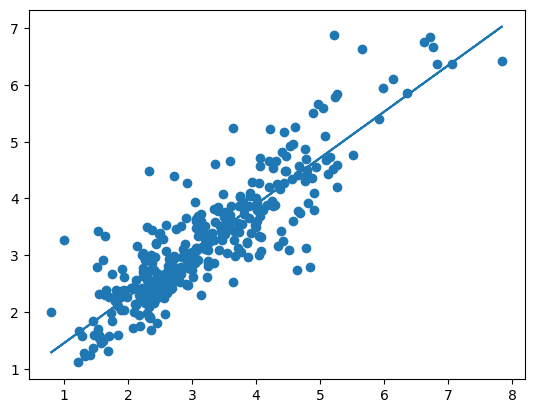

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#define data
x = np.array(comparison_df['Actual Dollar Price'])
y = np.array(comparison_df['Predicted Dollar Price'])

#find line of best fit
a, b = np.polyfit(x, y, 1)

#add points to plot
plt.scatter(x, y)

#add line of best fit to plot
plt.plot(x, a*x+b)

## Predict the Cost of a Big Mac
Create a new data sample.

In [15]:
#date	currency_code	local_price	dollar_ex	dollar_price

date = input('-> Enter a date [e.g., 5/15/2024]: ' )
currency_code = input('-> Enter a currency code [e.g., AUD, AZN, BHD]:')

-> Enter a date [e.g., 5/15/2024]: 05/25/2024
-> Enter a currency code [e.g., AUD, AZN, BHD]:BHD


## Setup the Data
This is very tricky because the model only understands the format of the training data. Our new sample doesn't have the all the currency codes, the dollar exchange rate, or the local currency value. For the sake of demonstration, these values are faked, but would be either gathered from the user or derived statistically.

Notice the new DataFrame looks exactly like X above.

In [42]:
new_sample_df = pd.DataFrame([[date]], columns=['date'])

# Re-create the one-hot encoding with the new sample.
for this_currency_code in reversed(all_currency_codes_array):
  if this_currency_code == currency_code:
    value = 1
  else:
    value = 0
  new_sample_df.insert(1, 'currency_code_' + this_currency_code, [value], True)


new_sample_df.insert(1, 'local_price',  1.50, True)
new_sample_df.insert(2, 'dollar_ex', 1.790000, True)

new_sample_df['date'] = new_sample_df['date'].apply(lambda x: create_timestamp(x))
new_sample_df

,date,local_price,dollar_ex,currency_code_AED,currency_code_ARS,currency_code_AUD,currency_code_AZN,currency_code_BHD,currency_code_BRL,currency_code_CAD,...,currency_code_SEK,currency_code_SGD,currency_code_THB,currency_code_TRY,currency_code_TWD,currency_code_UAH,currency_code_USD,currency_code_UYU,currency_code_VND,currency_code_ZAR
0,1716595200,1.5,1.79,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Predict the Price of a Big Mac
This uses the model to get a Big Mac Price, which may not be as accurate as it would normally be because of the exchange rate guess, but it serves the purpose for demonstration.

In [46]:
big_mac_price_pred = linear_regression_model.predict(new_sample_df)
print('The predicted Big Mac price on', date, 'using the currency code', currency_code, 'is:', '${:,.2f}'.format(big_mac_price_pred[0]) )

The predicted Big Mac price on 05/25/2024 using the currency code BHD is: $3.94
